In [ ]:


import os, random
from src.data import create_train_val_test_split
from src.utils import visualize_samples, plot_history, evaluate_and_report, make_gradcam_heatmap, overlay_heatmap
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from src.model import build_baseline_cnn
import matplotlib.pyplot as plt


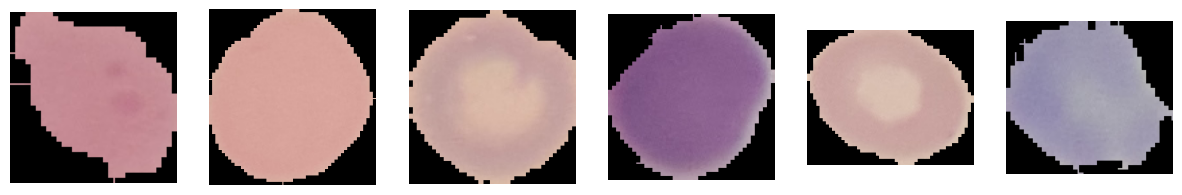

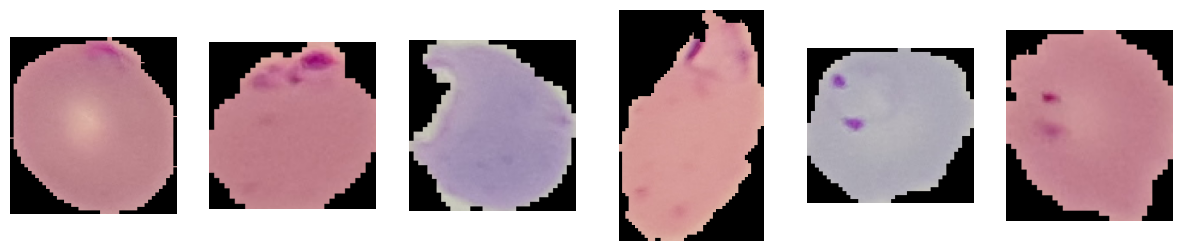

In [ ]:
# visualize some samples from the dataset
dataset_path = "cell_images"
visualize_samples(os.path.join(dataset_path, "Uninfected"), n_samples=6)
visualize_samples(os.path.join(dataset_path, "Parasitized"), n_samples=6)


In [ ]:
# create train, val, test splits
train_dir, val_dir, test_dir = create_train_val_test_split("cell_images", out_dir="data", val_ratio=0.2, test_ratio=0.1, copy=True)
print("Train, val, test created.")


Train, val, test created.


In [ ]:
# set up data generators
xy_shape = 64
BatchSize = 32

trainAug = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=20,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    horizontal_flip=True
)

testGen = ImageDataGenerator(rescale=1/255.0)

train_gen = trainAug.flow_from_directory("data/train", class_mode="binary", target_size=(xy_shape, xy_shape), batch_size=BatchSize)
val_gen   = testGen.flow_from_directory("data/val", class_mode="binary", target_size=(xy_shape, xy_shape), batch_size=BatchSize, shuffle=False)
test_gen  = testGen.flow_from_directory("data/test", class_mode="binary", target_size=(xy_shape, xy_shape), batch_size=BatchSize, shuffle=False)


Found 19292 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 201s 320ms/step - accuracy: 0.7884 - loss: 0.4757 - val_accuracy: 0.8909 - val_loss: 0.3055
Epoch 2/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 122s 202ms/step - accuracy: 0.9411 - loss: 0.1781 - val_accuracy: 0.9459 - val_loss: 0.1654
Epoch 3/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 120s 198ms/step - accuracy: 0.9473 - loss: 0.1596 - val_accuracy: 0.9407 - val_loss: 0.1845
Epoch 4/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 120s 199ms/step - accuracy: 0.9481 - loss: 0.1557 - val_accuracy: 0.9456 - val_loss: 0.1578
Epoch 5/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 119s 197ms/step - accuracy: 0.9487 - loss: 0.1544 - val_accuracy: 0.9537 - val_loss: 0.1300
Epoch 6/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 118s 196ms/step - accuracy: 0.9519 - loss: 0.1430 - val_accuracy: 0.9519 - val_loss: 0.1318
Epoch 7/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 118s 196ms/step - accuracy: 0.9535 - loss: 0.1423 - val_accuracy: 0.9506 - val_loss: 0.1413
Epoch 8/12
603/603 ━━━━━━━━━━━━━━━━━━━━ 119s 198ms/step - accuracy: 0.9551 -

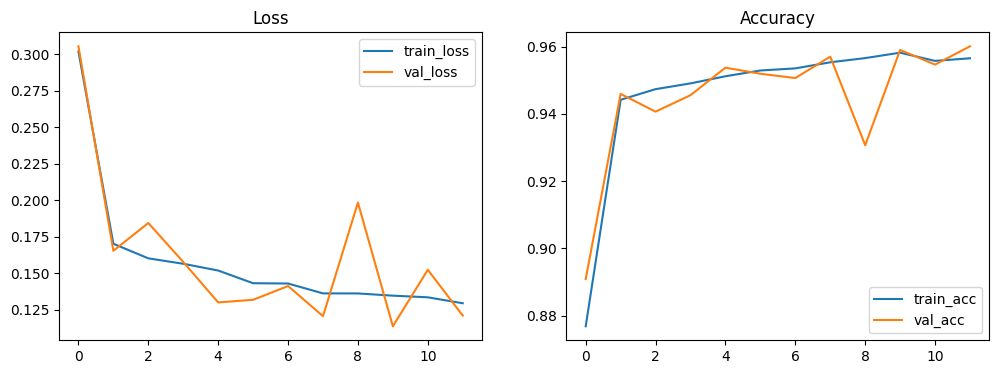

In [10]:
model = build_baseline_cnn(input_shape=(xy_shape, xy_shape, 3), dropout_rate=0.5)
history = model.fit(train_gen, validation_data=val_gen, epochs=12)
plot_history(history)


In [18]:
model.save("saved_models/baseline_cnn.keras")

87/87 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step
              precision    recall  f1-score   support

 Parasitized       0.97      0.95      0.96      1378
  Uninfected       0.95      0.97      0.96      1378

    accuracy                           0.96      2756
   macro avg       0.96      0.96      0.96      2756
weighted avg       0.96      0.96      0.96      2756



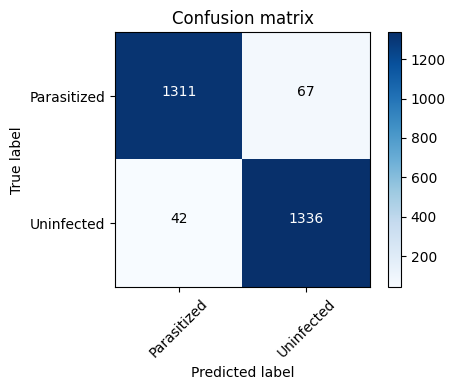

In [11]:
cm, report, y_true, y_pred = evaluate_and_report(model, test_gen)
print(report)
from src.utils import plot_confusion
plot_confusion(cm, classes=list(test_gen.class_indices.keys()), normalize=False)


In [13]:
from tensorflow.keras.preprocessing import image

# pick some test images (first 4)
fnames = test_gen.filepaths[:4]  # requires flow_from_directory with shuffle=False
for path in fnames:
    # preprocess single image
    img = plt.imread(path)
    import numpy as np
    img_resized = image.array_to_img(image.img_to_array(image.load_img(path, target_size=(xy_shape, xy_shape))))
    x = np.expand_dims(np.array(img_resized)/255.0, axis=0)
    heatmap = make_gradcam_heatmap(x, model)
    overlay = overlay_heatmap(path, heatmap)
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1); plt.imshow(plt.imread(path)); plt.title("Original"); plt.axis('off')
    plt.subplot(1,2,2); plt.imshow(overlay); plt.title("Grad-CAM"); plt.axis('off')
    plt.show()


AttributeError: The layer baseline_cnn has never been called and thus has no defined output.


---

## Quick usage notes & tips
- The `create_train_val_test_split` expects the original dataset to have subfolders per class (e.g., `cell_images/Parasitized`, `cell_images/Uninfected`). It copies files into `data/train`, `data/val`, `data/test`.
- For `evaluate_and_report` the generator must be created with `shuffle=False` so `generator.classes` aligns with predictions.
- Grad-CAM uses a heuristic to find the last convolutional layer. If it fails or produces small maps, pass the explicit layer name to `make_gradcam_heatmap`.
- Adjust `xy_shape` (image size) depending on your GPU memory. 64 or 128 are common baseline values.
- For reproducible experiments, set random seeds globally (NumPy/TensorFlow/Python `random`).

---

If you want, I can now:
- Produce the exact single-file `train.py` ready to run in Colab (I already provided `src/train.py` — I can convert it to a top-level runnable script), **or**
- Paste the full notebook as a downloadable `.ipynb` file here, **or**
- Run a short dry-run that verifies the notebook cell outputs (requires the dataset in this environment).

Which of those next steps do you want me to do now?
